In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import colorsys
import random

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def get_df(author):
    table = "parquet.`data/data.parquet`"
    author = "'{}'".format(author)
    return spark.sql('''
        SELECT {}, words
        FROM {} 
        WHERE author = {}
        '''.format(author, table, author))

# collect complete texts
def word_list(words):
    letters = set([x for x in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"])
    S = [w for w in words if w[0] in letters or (len(w)>1 and w[1] in letters)]
    return S

def get_all_text(df, table="parquet.`data/data.parquet`"):
    df.createOrReplaceTempView("T")
    tokens = spark.sql('''
        SELECT words
        FROM T
        ''')
    nest = [word_list(t['words']) for t in tokens.collect()]
    words_only = [item for sublst in nest for item in sublst]
    
    return " ".join(words_only)


authors = ["Twain", "Muir", "Austen", "Dickens"]
full_names = ['MarkTwain', 'JohnMuir', 'JaneAusten', 'CharlesDickens']
DFs = [get_df(n) for n in full_names]
colors = [(0.1, 0.3, .9), (0.1, 0.75, 0.55), (0.627,0.125,0.941), (0.9, 0.2, 0.1)]

texts = [get_all_text(d) for d in DFs]

DFs[0].show(5)

+---------+--------------------+
|MarkTwain|               words|
+---------+--------------------+
|MarkTwain|[a, connecticut, ...|
|MarkTwain|[“, you, know, ab...|
|MarkTwain|[how, sir, launce...|
|MarkTwain|[and, then, they,...|
|MarkTwain|[as, i, laid, the...|
+---------+--------------------+
only showing top 5 rows



## Build Word Clouds:

In [24]:
stopwords = set(STOPWORDS).union(set(['mr','one', 'said']))

def make_wordcloud(text, stopwords, color_func, mask_path, size=12, i=None):
    mask = np.array(Image.open(mask_path))
    wordcloud = WordCloud(width=1600, height=1600, background_color='white'
                          , stopwords=stopwords, mask=mask)\
                        .generate(text)
    plt.figure(figsize=(size, size))
    plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3))
    plt.axis("off")

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    hsl = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
    return "hsl({}, {}%, {}%)".format(int(hsl[0]*360), int(hsl[2]*100), int(hsl[1]*random.randint(40, 100)))

# in progress, trying to get 4 different colored plots in one grid
def cloudify(full_name=full_names, authors=authors, texts=texts, colors=colors, stopwords=stopwords):
    plt.subplots(2,2,sharex=True, sharey=True, figsize=(10,10))
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    for i, text in enumerate(texts):
        rgb = colors[i]
        mask_path = './images/{}.jpg'.format(full_names[i])
        mask = np.array(Image.open(mask_path))
        wordcloud = WordCloud(width=1600, height=1600, background_color='white'
                          , stopwords=stopwords, mask=mask)\
                        .generate(text)
        plt.subplot(2,2,i+1).imshow(wordcloud.recolor(color_func=color_func, random_state=3))
#         plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3))
        plt.axis("off")


In [25]:
# cloudify()

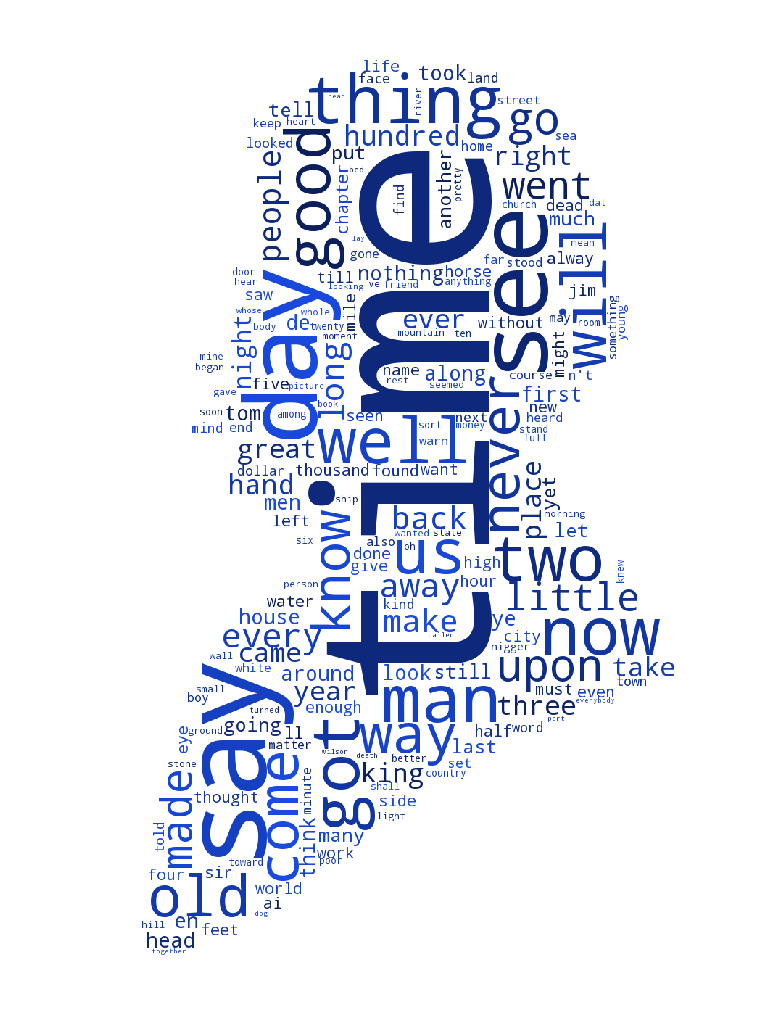

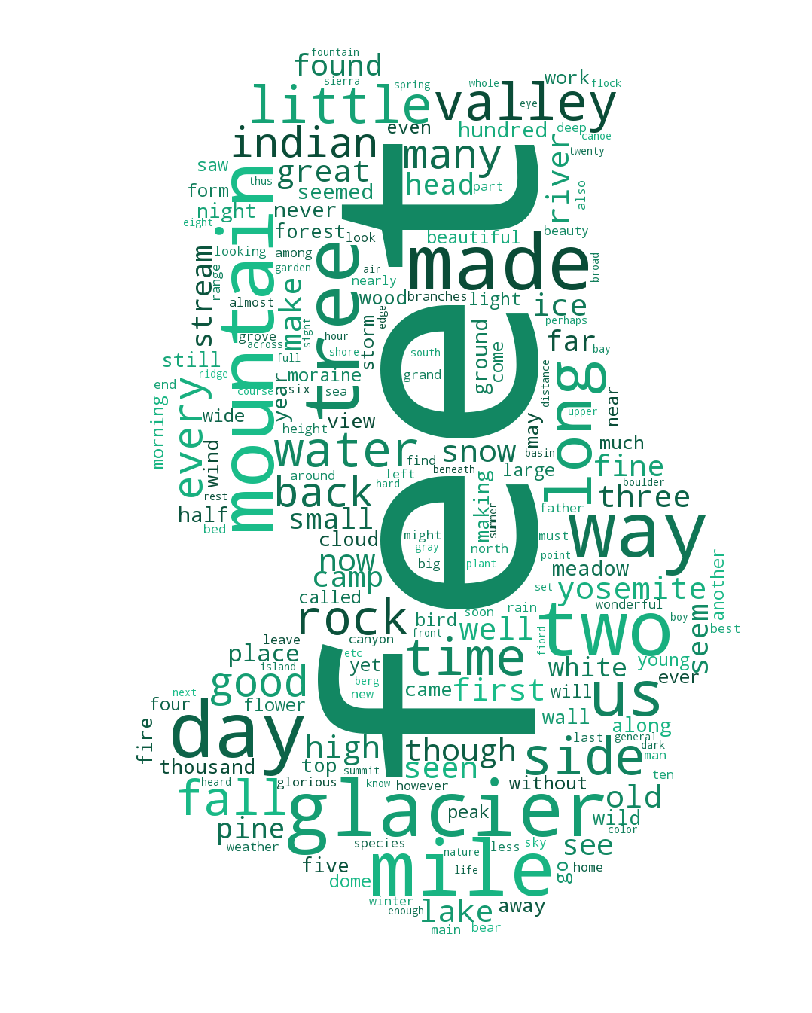

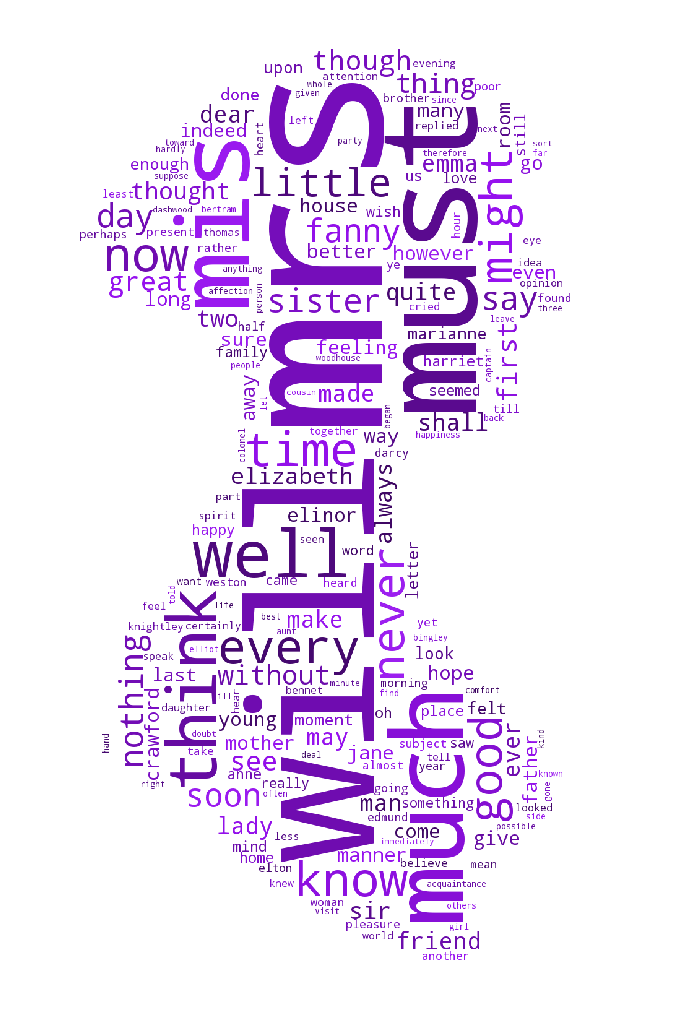

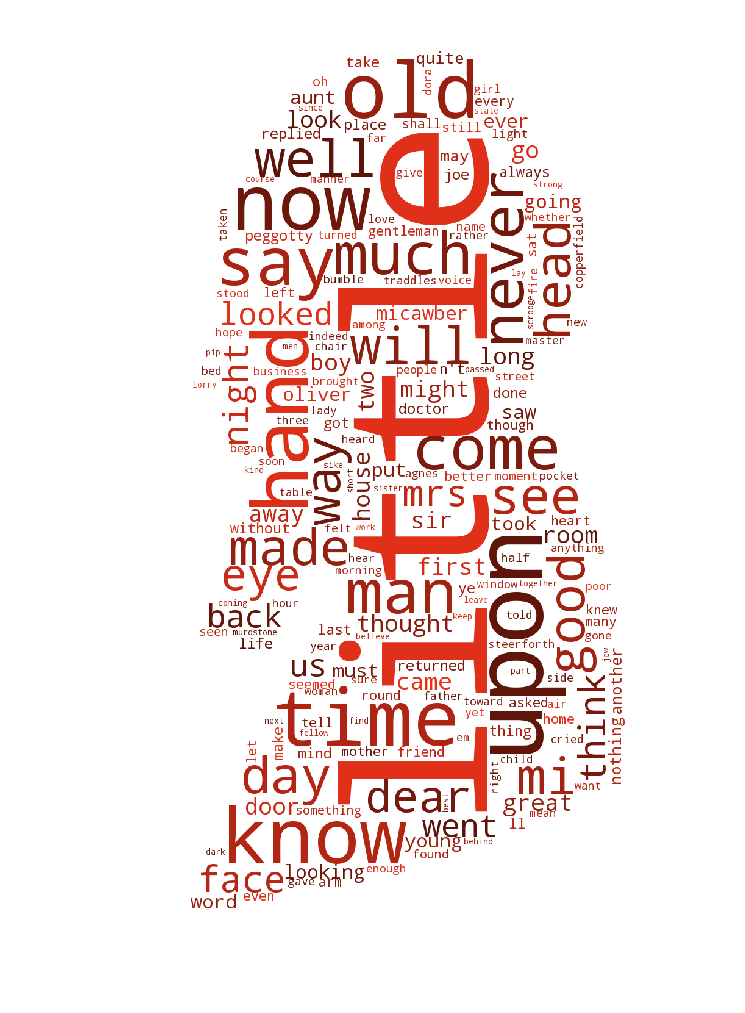

In [26]:
for n in range(4):
    rgb = colors[n]
    make_wordcloud(texts[n], stopwords, color_func
                   , './images/{}.jpg'.format(full_names[n]), size=18);
#     plt.savefig('./images/{}_cloud_2.png'.format(authors[n]))